In [1]:
import pandas as pd
import random
from definitions import get_node_color, get_node_id
import sys
import numpy as np
sys.path.append("./..")
from cell_graph import Cell_Graph
from soft_wl_subtree import Soft_WL_Subtree
import os
import pickle

### Extract Discovery set from Danenberg_et_al
* 1) data filtering: exclude patients with no clinical data and images with less than 500 cells
* 2) Random partition: for reproducibility purpose, we use a random seed.

In [2]:
# read single cell data and clinical data
cells = pd.read_csv("Datasets/Danenberg_et_al/cells.csv")
clinical = pd.read_csv("Datasets/Danenberg_et_al/clinical.csv")
print("Initially,")
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
        len(clinical["metabric_id"].unique()),
    )
)
# remove images without invasive tumor
print("\nRemove images without invasive tumor,")
cells = cells.loc[cells.isTumour == 1]
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
        len(clinical["metabric_id"].unique()),
    )
)
# remove patients with no clinical data
print("\nRemove patients with no clinical data,")
cells = cells.loc[cells["metabric_id"].isin(clinical["metabric_id"])]
print(
    "{} patients ({} images) with cell data and clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
    )
)
# remove images with less than 500 cells
print("\nRemove images with less than 500 cells")
cells_per_image = cells.groupby("ImageNumber").size()
cells = cells.loc[
    cells["ImageNumber"].isin(cells_per_image[cells_per_image > 500].index)
]
clinical = clinical.loc[clinical["metabric_id"].isin(cells["metabric_id"].unique())]
print(
    "{} patients ({} images) with more than 500 cells and clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
    )
)

random.seed(0)
Subset_id = [1] * (len(clinical) - 200) + [2] * 200
random.shuffle(Subset_id)
clinical['Subset_id'] = Subset_id
cells_discovery = cells.loc[cells["metabric_id"].isin(clinical.loc[clinical['Subset_id'] == 1, "metabric_id"])]
cells_validation = cells.loc[cells["metabric_id"].isin(clinical.loc[clinical['Subset_id'] == 2, "metabric_id"])]
print("\nAfter splitting into discovery and validation sets,")
print(
    "{} patients ({} images) with more than 500 cells and clinical data in the discovery set, ".format(
        len(cells_discovery["metabric_id"].unique()),
        len(cells_discovery["ImageNumber"].unique()),
    )
)

Initially,
718 patients (794 images) with cell data, 2604 patients with clinical data, 

Remove images without invasive tumor,
693 patients (749 images) with cell data, 2604 patients with clinical data, 

Remove patients with no clinical data,
683 patients (737 images) with cell data and clinical data, 

Remove images with less than 500 cells
579 patients (621 images) with more than 500 cells and clinical data, 

After splitting into discovery and validation sets,
379 patients (404 images) with more than 500 cells and clinical data in the discovery set, 


### Standardize data, and Generate cellular graphs

In [3]:
# Assign cell type Id based on meta description column
cells['cellTypeID'] = cells['meta_description'].map(get_node_id('Danenberg', 'CellType'))
# standardize column names
patientID_colname = "metabric_id"
imageID_colname = "ImageNumber"
celltypeID_colname = "cellTypeID"
coorX_colname = "Location_Center_X"
coorY_colname = "Location_Center_Y"
cells = cells.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

In [4]:
cell_graph_ = Cell_Graph(a = 0.01)
Cell_graphs = cell_graph_.generate(cells)
print("There are {} patients/cell graphs".format(len(Cell_graphs)))


cell_graph = Cell_graphs[0]
print("The first cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)")
print("\tThe first element is the patient id: {}".format(cell_graph[0]))
print("\tThe second element is the adjacnecy matrix, with the shape of {}".format(cell_graph[1].shape))
print("\tThe third element is the cell types, with the shape of {}".format(cell_graph[2].shape))
print(
        "There are {} cells with {} unique cell types".format(
            cell_graph[1].shape[0], np.unique(np.where(cell_graph[2] == 1)[1]).shape[0]
        )
    )


There are 579 patients/cell graphs
The first cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)
	The first element is the patient id: MB-0282
	The second element is the adjacnecy matrix, with the shape of (1624, 1624)
	The third element is the cell types, with the shape of (1624, 32)
There are 1624 cells with 28 unique cell types


### Identify TME patterns with Soft WL subtree kernel

In [5]:
if os.path.exists("fitted_soft_wl_subtree.pkl.npy"):
    print("There is a pre-fitted soft wl subtree kernel. We will load it directly.")
    with open("fitted_soft_wl_subtree.pkl", "rb") as f:
        soft_wl_subtree_ = pickle.load(f)
else:
    print("There is no pre-fitted soft wl subtree kernel. We will fit it now.")
    print("However, Excuting clustering algorithm on a extremely large matrix (e.g., 1016163 * 32) is prohibitive")
    print("Go run `python 3_TME_patterns.py` instead")


There is no pre-fitted soft wl subtree kernel. We will fit it now.
However, Excuting clustering algorithm on a extremely large matrix (e.g., 1016163 * 32) is prohibitive
Go run `python 3_TME_patterns.py` instead


### Visualize the Signature map

In [7]:
if os.path.exists("fitted_soft_wl_subtree.pkl"):
    print("There is a pre-fitted soft wl subtree kernel. We will load it directly.")
    with open("fitted_soft_wl_subtree.pkl", "rb") as f:
        soft_wl_subtree_ = pickle.load(f)
Signatures = soft_wl_subtree_.Signatures
Histograms = soft_wl_subtree_.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
# Proportion of each pattern presented in each patient's cellular graphs
DF_proportion = pd.DataFrame({})
index = 0
for i in range(Proportions.shape[0]):
    for j in range(Proportions.shape[1]):
        DF_proportion.loc[index, 'pattern_id'] = str(j)
        DF_proportion.loc[index, 'proportion'] = Proportions[i, j]
        index += 1

There is a pre-fitted soft wl subtree kernel. We will load it directly.


#### 1) Default order (sorted by pattern cluster size, descendent)

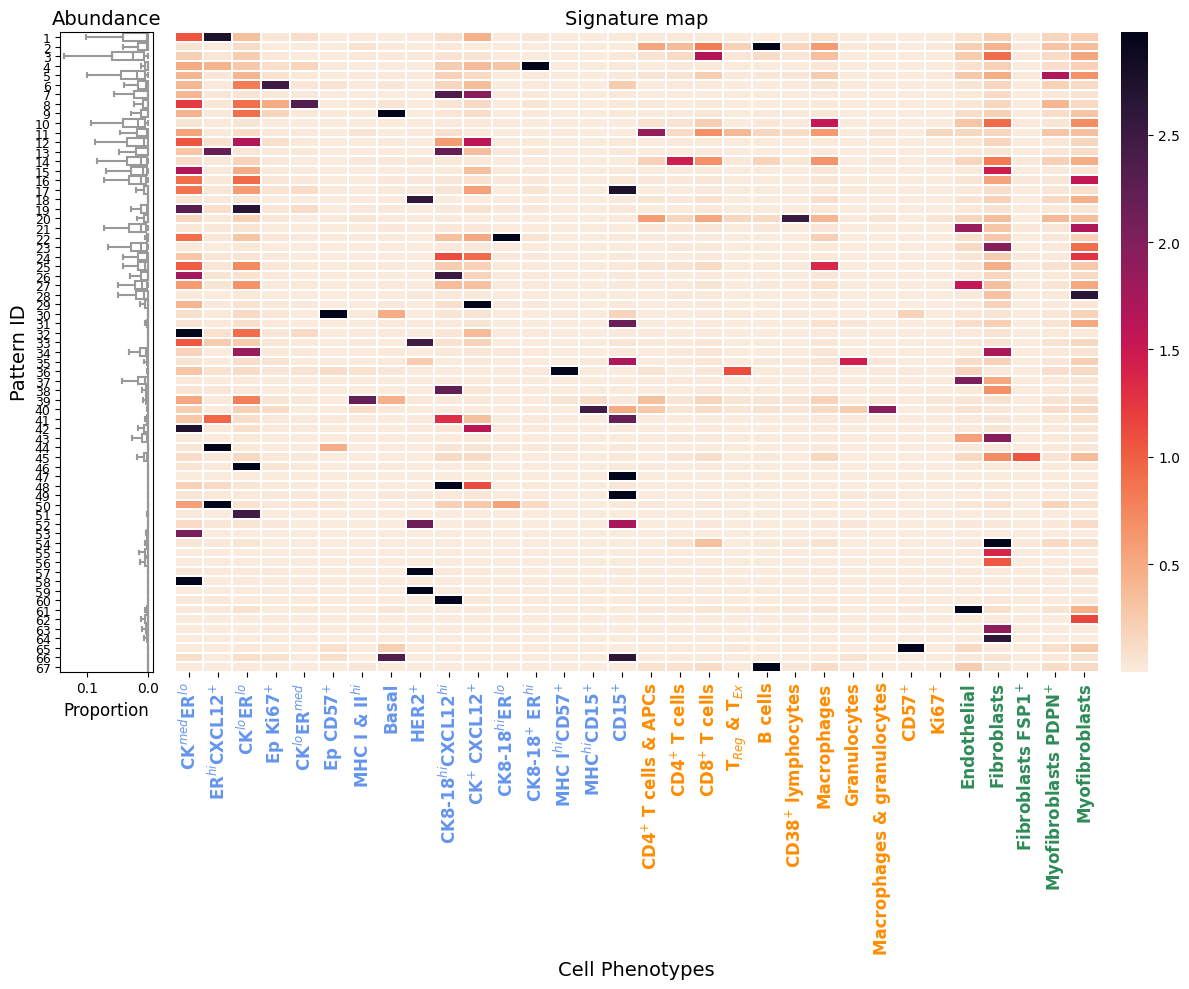

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from definitions import Cell_types_displayed_Danenberg
import pandas as pd
f, ax = plt.subplots(
    1,
    3,
    figsize=(12, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 10, 0.3]},
)
sns.heatmap(
    Signatures,
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signatures, 99),
    vmin=np.percentile(Signatures, 5),
)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=14)
ax[1].set_xticklabels(
    Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
)
ax[1].set_xlabel("Cell Phenotypes", fontsize=14)
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(
    y="pattern_id",
    x="proportion",
    data=DF_proportion,
    showfliers=False,
    ax=ax[0],
    color="white",
    order=[str(i) for i in range(Signatures.shape[0])],
    fliersize=0.5,
)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=14)
ax[0].set_yticklabels([i + 1 for i in range(Signatures.shape[0])], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=14)
ax[0].invert_xaxis()
plt.show()

#### 2) Reordered: gathered tme patterns by tumor niches, immune niches, stromal niches, and interfacing niches (Only for visualization purpose)

In [9]:
# Define tumor niches, immune niches, stromal niches, and interfacing niches
threshold = 0.5  # does not impact the downstream analysis, only imapct the presentation of the signature map
tumor_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 16:] > threshold, axis=1) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) > 0)
)[0]
interacting_niche = [
    i
    for i in range(Signatures.shape[0])
    if i not in np.concatenate([tumor_niche, immune_niche, stromal_niche])
]
print("There are {} identified TME patterns.".format(Signatures.shape[0]))
print(
    "There are {} tumor niches, {} immune niches, {} stromal niches, and {} interacting niches.".format(
        len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche)
    )
)

There are 67 identified TME patterns.
There are 34 tumor niches, 4 immune niches, 14 stromal niches, and 15 interacting niches.


#### Fig. 4 Abundance and Signature map of TME patterns.

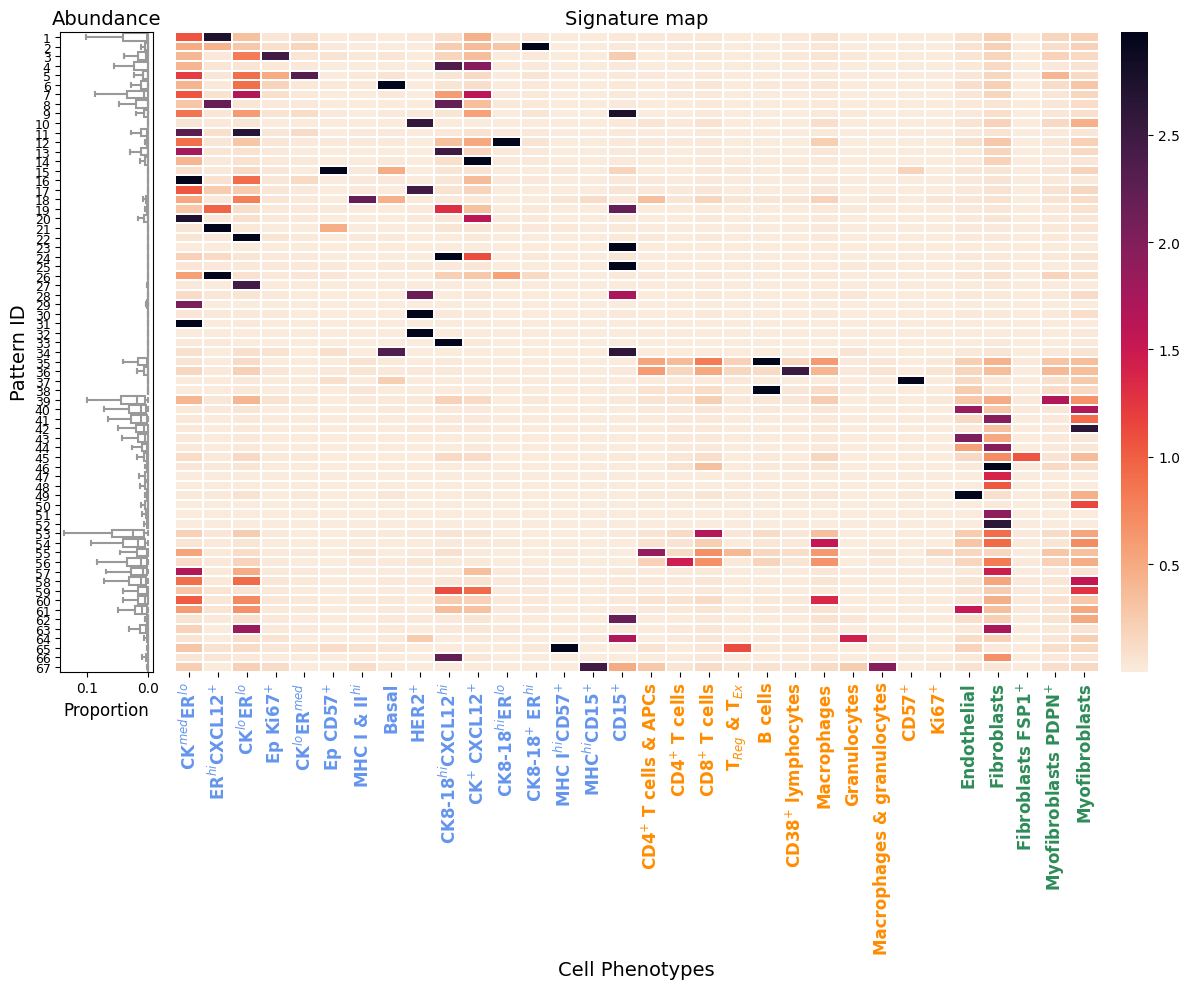

In [10]:
f, ax = plt.subplots(
    1,
    3,
    figsize=(12, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 10, 0.3]},
)
Indices = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])
sns.heatmap(
    Signatures[Indices, :],
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signatures, 99),
    vmin=np.percentile(Signatures, 5),
)

ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=14)
ax[1].set_xticklabels(
    Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
)
ax[1].set_xlabel("Cell Phenotypes", fontsize=14)
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(
    y="pattern_id",
    x="proportion",
    data=DF_proportion,
    showfliers=False,
    ax=ax[0],
    color="white",
    order=[str(i) for i in Indices],
    fliersize=0.5,
)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=14)
ax[0].set_yticklabels([i + 1 for i in range(len(Indices))], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=14)
ax[0].invert_xaxis()
plt.show()